#### **data : 얼굴 크롭한 사진(최종 정제 전)**
#### **model : Base Model에 Batch Normalization 적용**
#### **momentum=0.85**

### Import & mount

In [0]:
!kill -9 -1

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
import shutil
import zipfile
import random
from PIL import Image
import IPython.display as display

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models, datasets

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Extract zip file

In [0]:
root_dir = '/content/drive/Shared drives/scsa_2019_a/Project/dataset.zip'
zip_ref = zipfile.ZipFile(root_dir, 'r')
zip_ref.extractall("/")
zip_ref.close()

In [0]:
data_dir = pathlib.Path('/dataset_final')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

7399


In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'tmpwpnw1k1r'])
CLASS_NAMES

array(['jyp', 'woosung', 'yoonho', 'yuna', 'hoona', 'sodam', 'joon',
       'goeun', 'hyori', 'jisung', 'mingi', 'jaeseuk', 'iu', 'twice',
       'bts', 'youngae'], dtype='<U7')

### 랜덤한 숫자 뽑기

In [0]:
tf.io.gfile.mkdir('/testdata')

In [0]:
sep_test = True
if sep_test:
  for name in CLASS_NAMES:
    files = list(data_dir.glob(name + '/*'))
    randList = list(range(0, len(list(data_dir.glob(name + '/*')))))
    tf.io.gfile.mkdir('/testdata/' + name)
    randList = random.sample(randList, int(len(list(data_dir.glob(name + '/*'))) * 0.2))
    # print(randList)
    for n in randList:
      filedir = str(files[n])
      print(filedir)
      filename = filedir.split('/')[-1]
      shutil.move(filedir,  '/testdata/' + name + '/' + filename)

/dataset_final/jyp/jyp (60).jpg
/dataset_final/jyp/jyp (90).jpg
/dataset_final/jyp/jyp (48).jpg
/dataset_final/jyp/jyp (134).jpg
/dataset_final/jyp/jyp (27).jpg
/dataset_final/jyp/jyp (12).png
/dataset_final/jyp/jyp (125).jpg
/dataset_final/jyp/jyp (95).jpg
/dataset_final/jyp/jyp (118).jpg
/dataset_final/jyp/jyp (44).jpg
/dataset_final/jyp/jyp (86).jpg
/dataset_final/jyp/jyp (15).jpg
/dataset_final/jyp/jyp (75).jpg
/dataset_final/jyp/jyp (35).jpg
/dataset_final/jyp/jyp (236).jpg
/dataset_final/jyp/jyp (177).jpg
/dataset_final/jyp/jyp (162).jpg
/dataset_final/jyp/jyp (121).jpg
/dataset_final/jyp/jyp (252).jpg
/dataset_final/jyp/jyp (65).jpg
/dataset_final/jyp/jyp (281).jpg
/dataset_final/jyp/jyp (205).jpg
/dataset_final/jyp/jyp (273).jpg
/dataset_final/jyp/jyp (233).jpg
/dataset_final/jyp/jyp (56).jpg
/dataset_final/jyp/jyp (168).jpg
/dataset_final/jyp/jyp (138).jpg
/dataset_final/jyp/jyp (149).jpg
/dataset_final/jyp/jyp (219).jpg
/dataset_final/jyp/jyp (185).jpg
/dataset_final/jyp/jyp 

### Generator

In [0]:
# image generator for unziped directory 
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = (
    tf.keras.preprocessing.image.ImageDataGenerator(
        #width_shift_range=0.05,
        #height_shift_range=0.05,
        #horizontal_flip=True, 
        #vertical_flip=True,
        #rotation_range=30,
        validation_split=0.2,
        rescale=1./255))

image_generator_cwd = (
    tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)) # preprocessing이라는 모듈 밑에 이미지를 처리하는 애들이 있고, 그 안에 있음.

In [0]:
BATCH_SIZE = 128
IMG_HEIGHT = 128
IMG_WIDTH = 128

train_data_gen = image_generator.flow_from_directory(
                      directory="/dataset_final",
                      batch_size=BATCH_SIZE,
                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                      classes = list(CLASS_NAMES),
                      subset='training'
                      )

valid_data_gen = image_generator.flow_from_directory(
                      directory="/dataset_final",
                      batch_size=BATCH_SIZE,
                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                      classes = list(CLASS_NAMES),
                      subset='validation'
                      )
test_gen = image_generator_cwd.flow_from_directory(
                        directory="/testdata",
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        target_size=(IMG_HEIGHT, IMG_WIDTH), # target_size : 이미지들의 사이즈를 조작
                        classes = list(CLASS_NAMES)
                        )


Found 4747 images belonging to 16 classes.
Found 1178 images belonging to 16 classes.
Found 1474 images belonging to 16 classes.


### Build Model

In [0]:
def model_cnn():
  model = models.Sequential()
  # conv 1
  model.add(Conv2D(64,3,padding='same',activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  
  # conv 2
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # conv 3
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # conv 4
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # conv 5
  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  model.add(BatchNormalization(momentum=0.85))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Dense layers
  model.add(Flatten(name='flatten'))
  model.add(Dense( len(list(CLASS_NAMES)), activation='softmax'))

  return model

model = model_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       2

### Compile & Fit

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
%%time
epoch_n = 30
model_history = model.fit_generator(train_data_gen, 
                        epochs=epoch_n,
                        validation_data=valid_data_gen)

Epoch 1/30
38/38 [==============================] - 26s 673ms/step - loss: 2.0119 - acc: 0.4133 - val_loss: 1.4936 - val_acc: 0.5110
Epoch 2/30
38/38 [==============================] - 21s 554ms/step - loss: 1.0866 - acc: 0.6592 - val_loss: 1.0821 - val_acc: 0.6570
Epoch 3/30
38/38 [==============================] - 21s 555ms/step - loss: 0.7577 - acc: 0.7643 - val_loss: 0.9504 - val_acc: 0.7054
Epoch 4/30
38/38 [==============================] - 21s 553ms/step - loss: 0.4458 - acc: 0.8679 - val_loss: 0.8564 - val_acc: 0.7351
Epoch 5/30
38/38 [==============================] - 21s 555ms/step - loss: 0.3092 - acc: 0.9138 - val_loss: 0.7716 - val_acc: 0.7716
Epoch 6/30
38/38 [==============================] - 21s 557ms/step - loss: 0.2133 - acc: 0.9454 - val_loss: 1.0229 - val_acc: 0.6757
Epoch 7/30
38/38 [==============================] - 21s 556ms/step - loss: 0.1064 - acc: 0.9770 - val_loss: 0.6310 - val_acc: 0.8073
Epoch 8/30
38/38 [==============================] - 21s 555ms/step - 

In [0]:
print(np.max(model_history.history['val_acc']))

0.8633277


### Plot

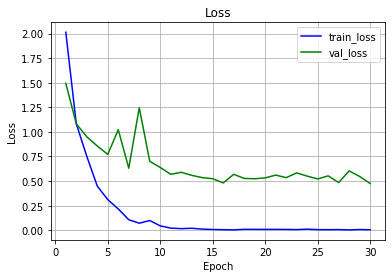

In [0]:
loss = model_history.history['loss']
epochs = range(1, len(loss)+1)

plt.title('Loss')
plt.plot(epochs, model_history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, model_history.history['val_loss'], 'g', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

### Evaluation

In [0]:
test_accuracy = model.evaluate_generator(test_gen, verbose=2)

12/12 - 2s - loss: 0.5451 - acc: 0.8704


In [0]:
# def show_batch(data_gen, class_l):
#   # get image and label from data generator
#   img_batch, l_batch = next(data_gen) 
#   plt.figure(figsize=(10,10))
#   ret = []
#   img_title = model.predict(img_batch)
#   for img in img_title:
#     ret.append(np.array(img).argmax())
#   for n in range(16):
#     ax = plt.subplot(4,4,n+1)
#     plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.5, wspace=0.2)
#     plt.imshow(img_batch[n])
#     title_name = 'label = ' + class_l[l_batch[n]==1][0] + "   \n" + "judge = " + CLASS_NAMES[ret[n]]
#     plt.title(title_name)
#     plt.axis('off')

# show_batch(test_gen, CLASS_NAMES)

### Confusion Matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

num_test = 1474

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_gen, num_test // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

Confusion Matrix
[[ 50   0   0   1   0   0   0   2   0   0   0   1   0   0   0   0]
 [  0  75   0   0   0   0   2   0   1   0   6   0   1   0   1   0]
 [  1   1  34   1   0   1   0   0   1   1   1   0   1   0   6   0]
 [  0   0   0  81   0   2   0   2   0   0   0   0   0   2   1   0]
 [  0   1   0   0  27   0   0   0   0   0   1   2   0   0   0   0]
 [  0   0   0   4   0 109   0  12   0   0   1   1   2   1   1   1]
 [  1   0   0   0   1   1  26   1   0   0   0   1   0   0   0   0]
 [  1   0   0   3   0   4   0 159   1   1   0   0   2   2   2   2]
 [  1   0   0   5   0   1   0   4  50   1   0   1   6   3   1   2]
 [  0   0   0   0   0   0   0   0   0  25   1   2   0   0   0   0]
 [  0   2   1   0   0   0   0   0   1   2  98   1   3   0   5   0]
 [  1   0   0   0   0   0   1   0   0   0   1  98   1   0   1   0]
 [  0   0   2   0   0   1   0   0   7   0   0   0 152   7   8   0]
 [  0   0   0   2   0   1   0   1   1   0   0   0   5 154   0   1]
 [  0   0   0   0   0   1   0   1   1   0   3

In [0]:
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=CLASS_NAMES))

Classification Report
              precision    recall  f1-score   support

         jyp       0.91      0.93      0.92        54
     woosung       0.95      0.87      0.91        86
      yoonho       0.92      0.71      0.80        48
        yuna       0.83      0.92      0.87        88
       hoona       0.96      0.87      0.92        31
       sodam       0.90      0.83      0.86       132
        joon       0.90      0.84      0.87        31
       goeun       0.87      0.90      0.88       177
       hyori       0.78      0.67      0.72        75
      jisung       0.83      0.89      0.86        28
       mingi       0.88      0.87      0.87       113
     jaeseuk       0.92      0.95      0.93       103
          iu       0.84      0.86      0.85       177
       twice       0.90      0.93      0.92       165
         bts       0.81      0.90      0.85       128
     youngae       0.83      0.79      0.81        38

    accuracy                           0.87      1474
   m